# Assignment 2024 - 2025: NLP Sentiment Analysis

# Team: Orfeas Ilias Gkonis,Nikolaos Laoutaris

## 1. Introduction

Natural Language Processing (NLP) is presently among the hottest scientific fields with an enormous growth rate of the relevant research. Sentiment analysis is a popular NLP problem that aims at the automatic identification of the polarity in user reviews, tweets, blog posts, comments, forum discussions and so on.

In the vast majority of cases, sentiment analysis is treated as a text classification problem. If the involved text polarity is binary (i.e., positive or
negative, good or bad), then binary text classification models are trained by
utilizing two class labels. On the other hand, in case the polarity falls into a
closed score range (e.g., 1–5, 1–10, etc.), then each individual score is treated
as a separate class label and multi-class classification approaches are applied.

In this assignment you will explore various classifiers on NLP sentiment analysis. The purpose is to measure their performance on a dataset that derives from X (formerly Twitter) and contains user opinions about a US Airliner.


### Classifiers
The classifiers to be studied are:
* $C_1$: Logistic Regression
* $C_2$: Support Vector Machines (Linear kernel) - hint: use [`LinearSVC`](https://scikit-learn.org/dev/modules/generated/sklearn.svm.LinearSVC.html)
* $C_3$: Random Forests
* $C_4$: Feed-forward Neural Network


### Dataset

The classification performance of the abovementioned models will be studied on the `Twitter_US_Airline_Sentiment.csv` dataset ([see more details here](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment)).



## 2. Experiments

You will vectorize the text (located in the column `text`) by using the well-known TF-IDF technique. There will be three cases where the vocabulary of `TfidfVectorizer` will be limited to:

1. Contain words that appear in at least 5 documents (hint: `min_df` parameter of `TfidfVectorizer`).
2. Contain 2500 words (hint: `max_features` parameter of `TfidfVectorizer`).
3. Contain 500 words (hint: `max_features` parameter of `TfidfVectorizer`).

The classifiers will be evaluated by using 5-fold cross validation. Make sure that no information will be leaked from the training set to the test set. The values of the four following metrics will be measured:

* $M_1$: Accuracy
* $M_2$: F1-score
* $M_3$: Fit time


## Solution


Obviously first we import everything we're going to need.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import matplotlib.pyplot as plt

Let's load the dataset and see what we're dealing with.

In [3]:
df = pd.read_csv('Twitter_US_Airline_Sentiment.csv')
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


We now split the dataset into input and target variables.

In [7]:
X = df['text']
Y = df['airline_sentiment']

Finally, we make a couple of collections for the scorers and classifiers we're going to be using during cross-validation. The parameters were chosen through trial and error.

In [10]:
scorers = {
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score, average='weighted')
    # fit time already exists as an output of the method
}

classifiers = [
    LogisticRegression(C=1, solver='liblinear', random_state=1),
    LinearSVC(C=1, random_state=1),
    RandomForestClassifier(n_estimators=200, min_samples_split=5,  n_jobs=-1, random_state=1),
    MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, solver='adam', random_state=1)
]


We're all set! We chose to examine each vectorizer case in a different cell block for the sake of code readability.
Please note that the use of pipelines ensures that no data is leaked.

In [13]:
# Case 1: Contain words that appear in at least 5 documents
vectorizer1 = TfidfVectorizer(min_df=5)

cv_results_v1 = []
for classifier in classifiers:
    pipe1 = Pipeline([('vectorizer', vectorizer1), ('classifier', classifier)])
    scores = cross_validate(pipe1, X, Y, cv=5, scoring=scorers, return_train_score=False, n_jobs=-1)
    cv_results_v1.append({
            'Classifier': classifier.__class__.__name__,
            'Accuracy': scores['test_accuracy_score'].mean(),
            'F1-Score': scores['test_f1_score'].mean(),
            'Fit Time': scores['fit_time'].mean(),
        })
results_v1_df = pd.DataFrame(cv_results_v1).set_index("Classifier")
results_v1_df

,Accuracy,F1-Score,Fit Time
Classifier,,,
LogisticRegression,0.757104,0.732699,0.316618
LinearSVC,0.757650,0.748931,0.336595
RandomForestClassifier,0.708265,0.675152,5.390736
MLPClassifier,0.709631,0.709324,257.075715


In [14]:
# Case 2: Contain 2500 words
vectorizer2 = TfidfVectorizer(max_features=2500)

cv_results_v2 = []
for classifier in classifiers:
    pipe2 = Pipeline([('vectorizer', vectorizer2), ('classifier', classifier)])
    scores = cross_validate(pipe2, X, Y, cv=5, scoring=scorers, return_train_score=False, n_jobs=-1)
    cv_results_v2.append({
            'Classifier': classifier.__class__.__name__,
            'Accuracy': scores['test_accuracy_score'].mean(),
            'F1-Score': scores['test_f1_score'].mean(),
            'Fit Time': scores['fit_time'].mean(),
        })
results_v2_df = pd.DataFrame(cv_results_v2).set_index("Classifier")
results_v2_df

,Accuracy,F1-Score,Fit Time
Classifier,,,
LogisticRegression,0.758265,0.734282,0.304654
LinearSVC,0.761066,0.751809,0.323443
RandomForestClassifier,0.706899,0.672644,9.195278
MLPClassifier,0.709904,0.707279,207.846177


In [15]:
# Case 3: Contain 500 words
vectorizer3 = TfidfVectorizer(max_features=500)

cv_results_v3 = []
for classifier in classifiers:
    pipe3 = Pipeline([('vectorizer', vectorizer3), ('classifier', classifier)])
    scores = cross_validate(pipe3, X, Y, cv=5, scoring=scorers, return_train_score=False, n_jobs=-1)
    cv_results_v3.append({
            'Classifier': classifier.__class__.__name__,
            'Accuracy': scores['test_accuracy_score'].mean(),
            'F1-Score': scores['test_f1_score'].mean(),
            'Fit Time': scores['fit_time'].mean(),
        })
results_v3_df = pd.DataFrame(cv_results_v3).set_index("Classifier")
results_v3_df

,Accuracy,F1-Score,Fit Time
Classifier,,,
LogisticRegression,0.742623,0.719271,0.320981
LinearSVC,0.746585,0.732470,0.320825
RandomForestClassifier,0.695902,0.668760,9.325817
MLPClassifier,0.716667,0.709162,15.867475


This is an attempt to visualize the results of comparing the different classifiers across different vectorizer cases.

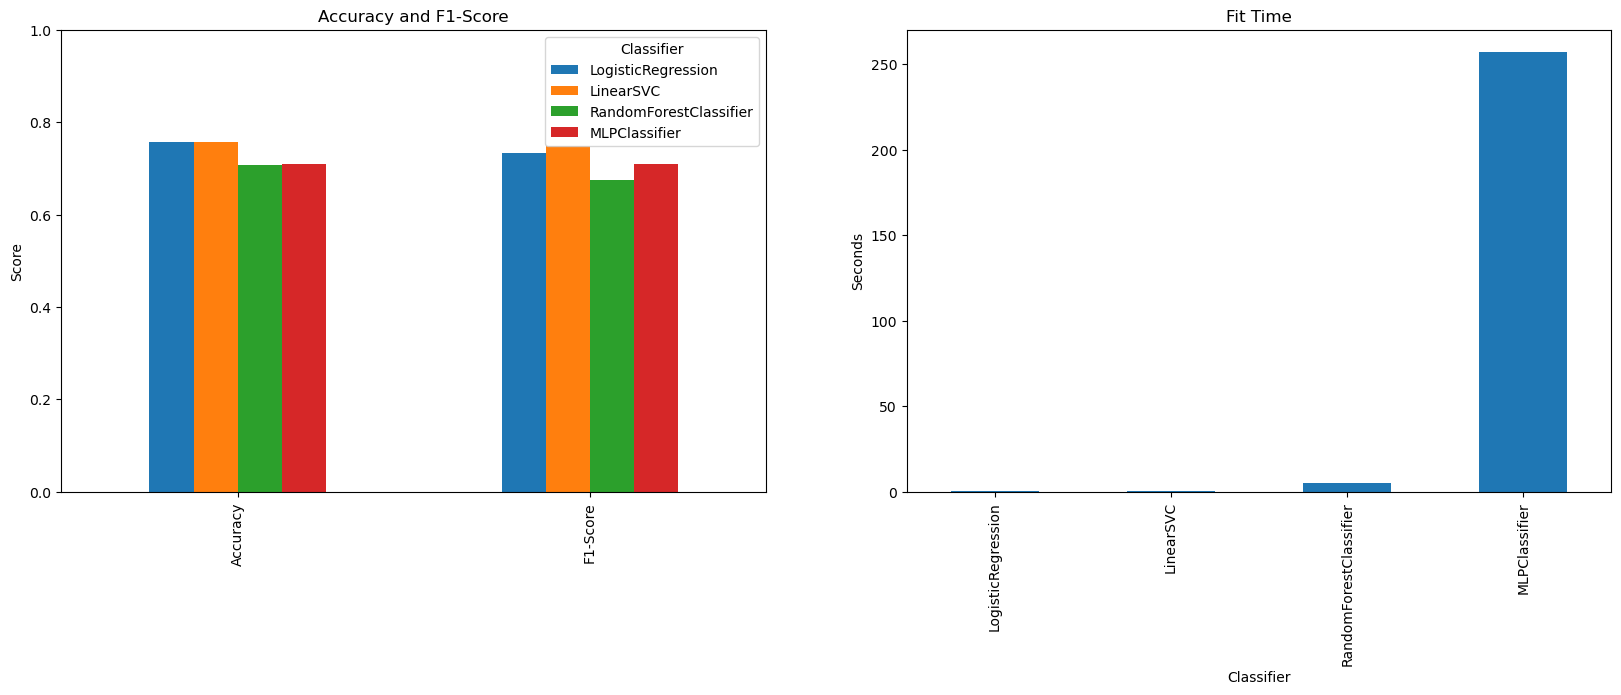

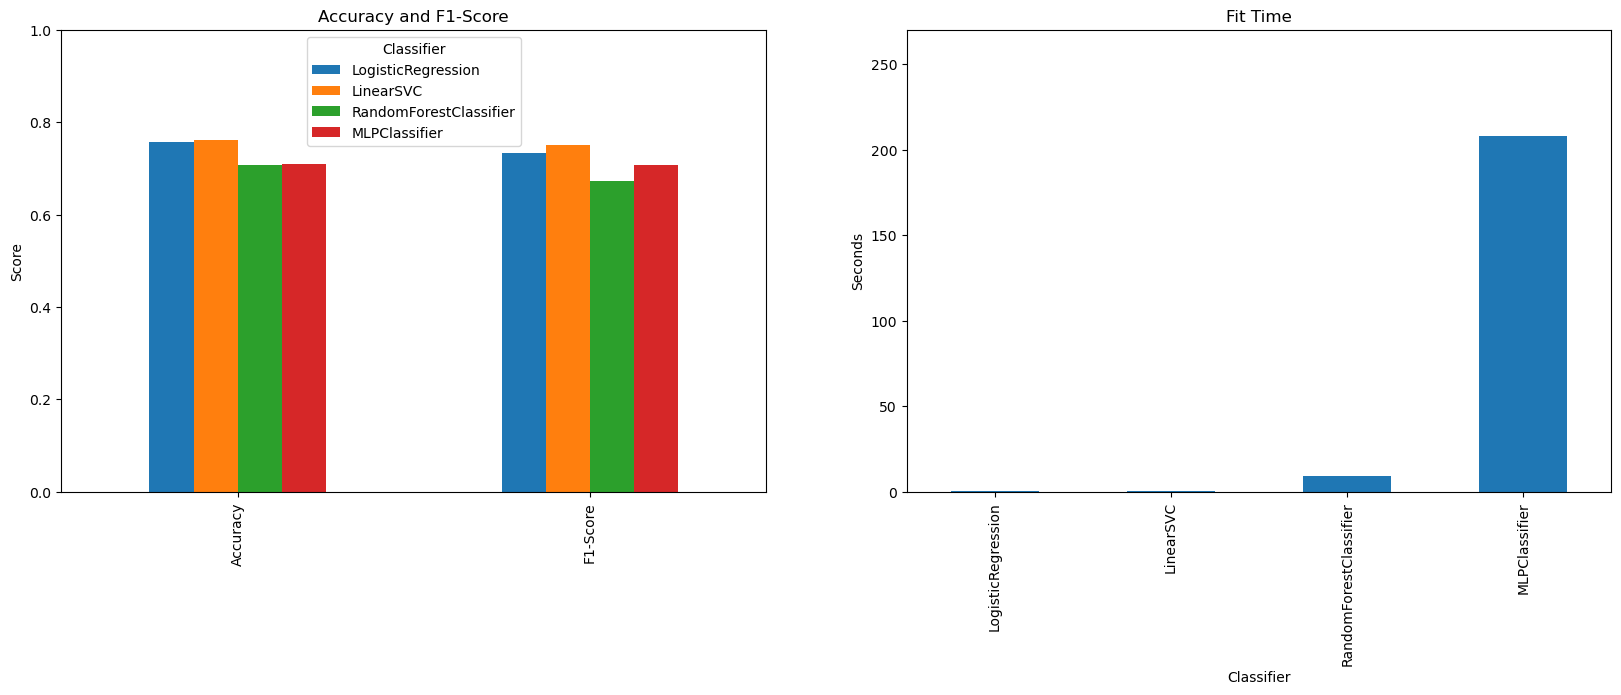

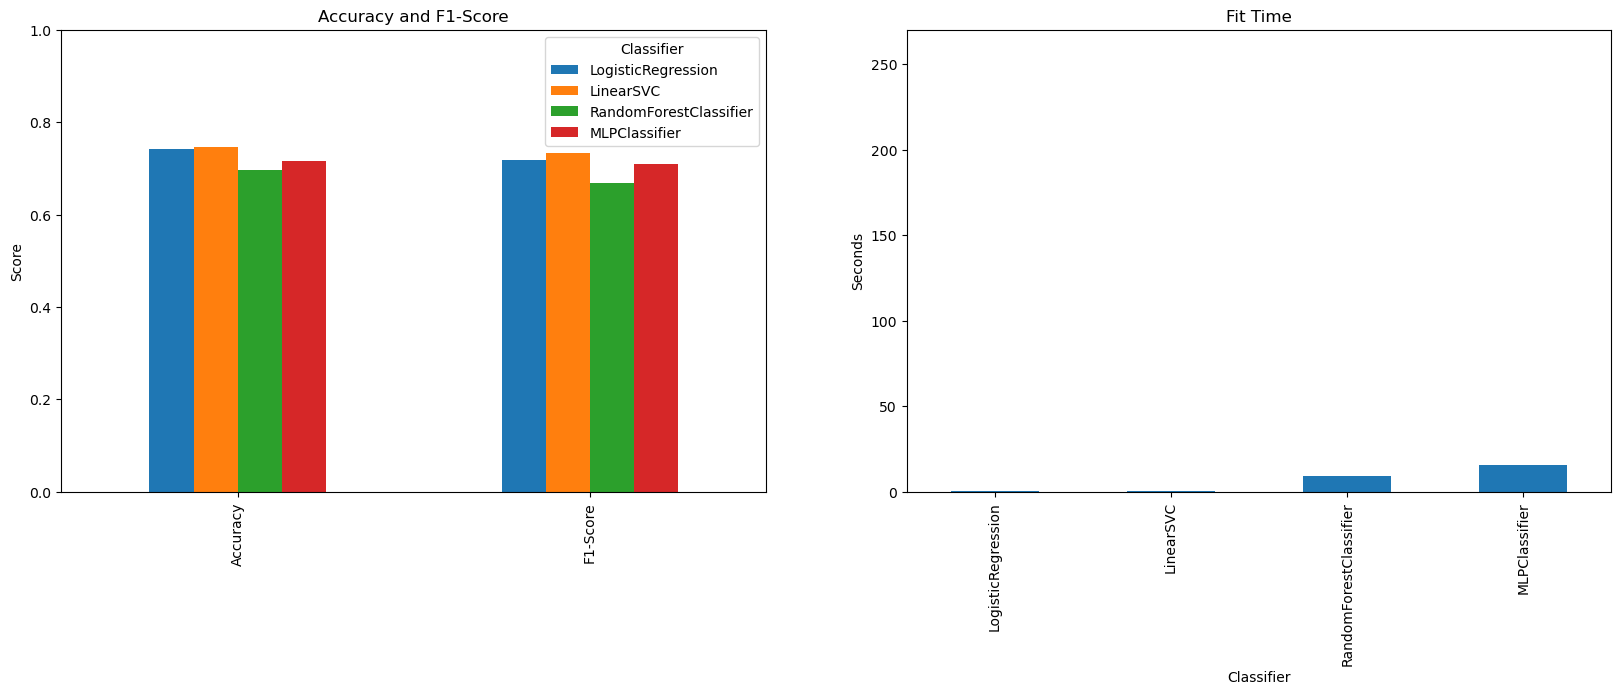

In [17]:
max_fit_time = max(result['Fit Time'].max() for result in [results_v1_df, results_v2_df, results_v3_df])

for result in [results_v1_df, results_v2_df, results_v3_df]:
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    result[['Accuracy', 'F1-Score']].T.plot(kind='bar', ax=ax[0])
    ax[0].set_ylim(0, 1)
    ax[0].set_ylabel('Score')
    ax[0].set_title('Accuracy and F1-Score')

    result['Fit Time'].plot(kind='bar', ax=ax[1])
    ax[1].set_ylim(0, max_fit_time * 1.05)
    ax[1].set_ylabel('Seconds')
    ax[1].set_title('Fit Time')
    plt.show()


Next, we try to showcase the effect of standard-normalization in the pipeline. We chose the second case as a test.

In [19]:
from sklearn.preprocessing import StandardScaler
vectorizer4 = TfidfVectorizer(max_features=2500)

cv_results_v4 = []
for classifier in classifiers:
    pipe4 = Pipeline([('vectorizer', vectorizer4), ('scaler', StandardScaler(with_mean=False)), ('classifier', classifier)])
    scores = cross_validate(pipe4, X, Y, cv=5, scoring=scorers, return_train_score=False, n_jobs=-1)
    cv_results_v4.append({
            'Classifier': classifier.__class__.__name__,
            'Accuracy': scores['test_accuracy_score'].mean(),
            'F1-Score': scores['test_f1_score'].mean(),
            'Fit Time': scores['fit_time'].mean(),
        })
results_v4_df = pd.DataFrame(cv_results_v4).set_index("Classifier")
results_v4_df

,Accuracy,F1-Score,Fit Time
Classifier,,,
LogisticRegression,0.708197,0.705795,0.705134
LinearSVC,0.699249,0.699542,2.465366
RandomForestClassifier,0.706967,0.672686,9.434184
MLPClassifier,0.736817,0.731284,86.172787


Finally, we explored the use of text preprocessing as a preliminary step to check if it impacts our metrics. As before, we use the second case as a test.

In [44]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:)|(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' .join(emoticons).replace('-', ''))
    ret_text = ""
    for word in text.split():
        if word not in stop:
            ret_text += word + " "
    ret_text = ret_text.strip()
    if len(ret_text) == 0:
        ret_text = "Invalid"
    return ret_text
X_processed = X.apply(preprocessor)
X_processed

<>:9: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\W'
C:\Users\giorg\AppData\Local\Temp\ipykernel_20280\2042355300.py:9: SyntaxWarning: invalid escape sequence '\W'
  text = (re.sub('[\W]+', ' ', text.lower()) + ' ' .join(emoticons).replace('-', ''))
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giorg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                              virginamerica dhepburn said
1        virginamerica plus added commercials experienc...
2        virginamerica today must mean need take anothe...
3        virginamerica really aggressive blast obnoxiou...
4                       virginamerica really big bad thing
                               ...                        
14635       americanair thank got different flight chicago
14636    americanair leaving 20 minutes late flight war...
14637    americanair please bring american airlines bla...
14638    americanair money change flight answer phones ...
14639    americanair 8 ppl need 2 know many seats next ...
Name: text, Length: 14640, dtype: object

In [46]:
vectorizer5 = TfidfVectorizer(max_features=2500)

cv_results_v5 = []
for classifier in classifiers:
    pipe5 = Pipeline([('vectorizer', vectorizer5), ('classifier', classifier)])
    scores = cross_validate(pipe5, X_processed, Y, cv=5, scoring=scorers, return_train_score=False, n_jobs=-1)
    cv_results_v5.append({
            'Classifier': classifier.__class__.__name__,
            'Accuracy': scores['test_accuracy_score'].mean(),
            'F1-Score': scores['test_f1_score'].mean(),
            'Fit Time': scores['fit_time'].mean(),
        })
results_v5_df = pd.DataFrame(cv_results_v5).set_index("Classifier")
results_v5_df

,Accuracy,F1-Score,Fit Time
Classifier,,,
LogisticRegression,0.732445,0.702259,0.378297
LinearSVC,0.731352,0.719762,0.239345
RandomForestClassifier,0.692623,0.660743,4.488382
MLPClassifier,0.692623,0.689845,232.231349


# Discussion
 Although, Random Forests and Multi Layer Perceptron provide moderately good performance, in our opinion, they shouldn't be used in this dataset because of large fit time and lower accuarcy than Logistic Regression and SVM. We observe that the Logistic Regression and SVM models outperform the other two, albeit marginally, but for a fraction of their fit time. Between the two, we conclude that SVM is the most suitable for this specific task.
We tried using Standard Scaler after vectorizing in the pipeline,we observed that standardization reduces the acuraccy of all the classifiers except MLP which greatly improves the acuraccy and fit time.In our opinion, standardization should not be implimented because the acuraccy of the best classifier without it (SVM) is still better than MLP.Additionally, we applied some text cleaning such as removing punctuation and stop words, the results showed that the overall acuraccy for all the classifiers dropped but the fit time also dropped.Again, we think that this preprocessing step should not be implemented,because the trade off is not worth it.